<a href="https://colab.research.google.com/github/malvarezgarcia1213-png/Project-I-Deep-Learning-Image-Classification-with-CNN/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assessment Components
1. Data Preprocessing:

- Data loading and preprocessing (e.g., normalization, resizing, augmentation).
- Create visualizations of some images, and labels.

In [2]:
import kagglehub

# Download latest version
zip_path = kagglehub.dataset_download("alessiocorrado99/animals10")
print("Dataset descargado en:", zip_path)

Using Colab cache for faster access to the 'animals10' dataset.
Dataset descargado en: /kaggle/input/animals10


In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from collections import Counter
import pandas as pd

Traduccion del diccionario

In [4]:
dataset_dir = "/kaggle/input/animals10/raw-img"  # Ajusta según donde esté tu carpeta

# Diccionario de traducción italiano -> inglés
translate_to_english = {
    "cane": "dog",
    "gatto": "cat",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "mucca": "cow",
    "pecora": "sheep",
    "ragno": "spider",
    "scoiattolo": "squirrel"
}


In [5]:
# Data augmentation para el entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,                  # Normalizar pixeles
    rotation_range=10,                # Rotaciones más moderadas para evitar blur extremo
    width_shift_range=0.1,            # Desplazamiento horizontal ligero
    height_shift_range=0.1,           # Desplazamiento vertical ligero
    shear_range=0.15,                 # Transformación de corte moderada
    zoom_range=0.15,                  # Zoom más suave
    horizontal_flip=True,             # Volteo horizontal
    vertical_flip=False,              # Mantener si las imágenes no deben invertirse verticalmente
    brightness_range=[0.9,1.1],       # Variación de brillo ligera
    channel_shift_range=15,           # Ajuste de color sutil (funciona en color, deja B/N igual)
    fill_mode='nearest',              # Cómo rellenar los pixeles vacíos
    validation_split=0.2              # Separación de validación
)

In [6]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,         # Rotaciones más suaves
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=False,      # Solo si tiene sentido
    brightness_range=[0.9,1.1], # Brillo ligero
    fill_mode='nearest'
)

In [7]:
img_height, img_width = 224, 224
batch_size = 64

# --- Generadores ---
train_gen = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


/tmp/ipython-input-1657819176.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Class", y="Count", data=train_df, palette="viridis")


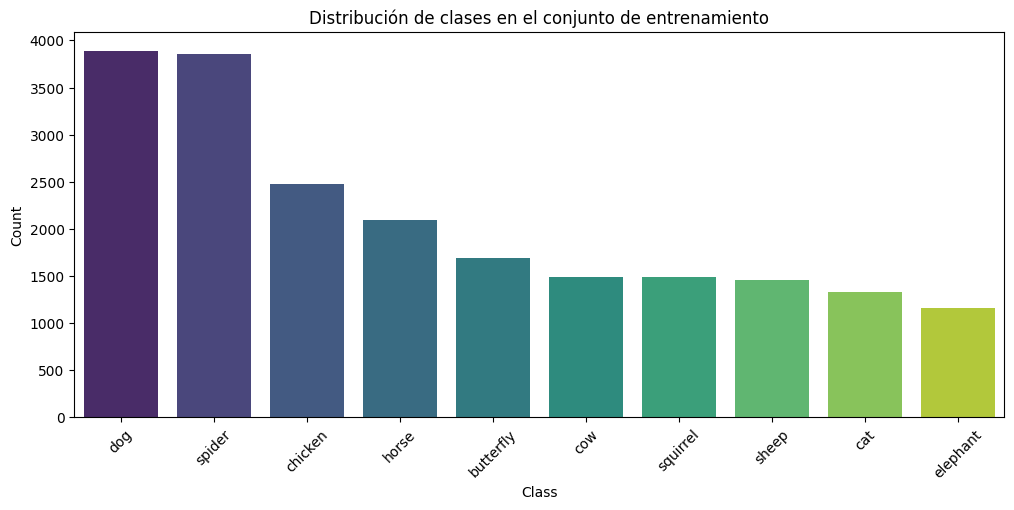

/tmp/ipython-input-1657819176.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Class", y="Count", data=val_df, palette="magma")


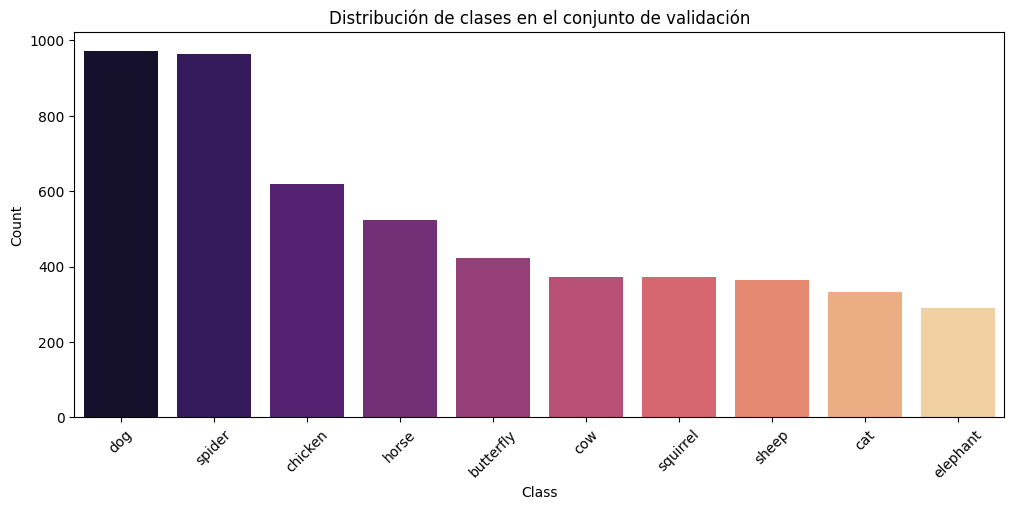

In [8]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- Analizar distribución de clases ---
train_counts = Counter(train_gen.classes)
val_counts = Counter(val_gen.classes)

# --- DataFrame para entrenamiento ---
train_df = pd.DataFrame(list(train_counts.items()), columns=["Class", "Count"])
train_df["Class"] = train_df["Class"].apply(lambda x: list(train_gen.class_indices.keys())[x])
train_df["Class"] = train_df["Class"].map(lambda x: translate_to_english.get(x, x))
train_df = train_df.sort_values("Count", ascending=False)

# --- DataFrame para validación ---
val_df = pd.DataFrame(list(val_counts.items()), columns=["Class", "Count"])
val_df["Class"] = val_df["Class"].apply(lambda x: list(val_gen.class_indices.keys())[x])
val_df["Class"] = val_df["Class"].map(lambda x: translate_to_english.get(x, x))
val_df = val_df.sort_values("Count", ascending=False)

# --- Graficar entrenamiento ---
plt.figure(figsize=(12,5))
sns.barplot(x="Class", y="Count", data=train_df, palette="viridis")
plt.xticks(rotation=45)
plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.show()

# --- Graficar validación ---
plt.figure(figsize=(12,5))
sns.barplot(x="Class", y="Count", data=val_df, palette="magma")
plt.xticks(rotation=45)
plt.title("Distribución de clases en el conjunto de validación")
plt.show()

Visualización de ejemplos

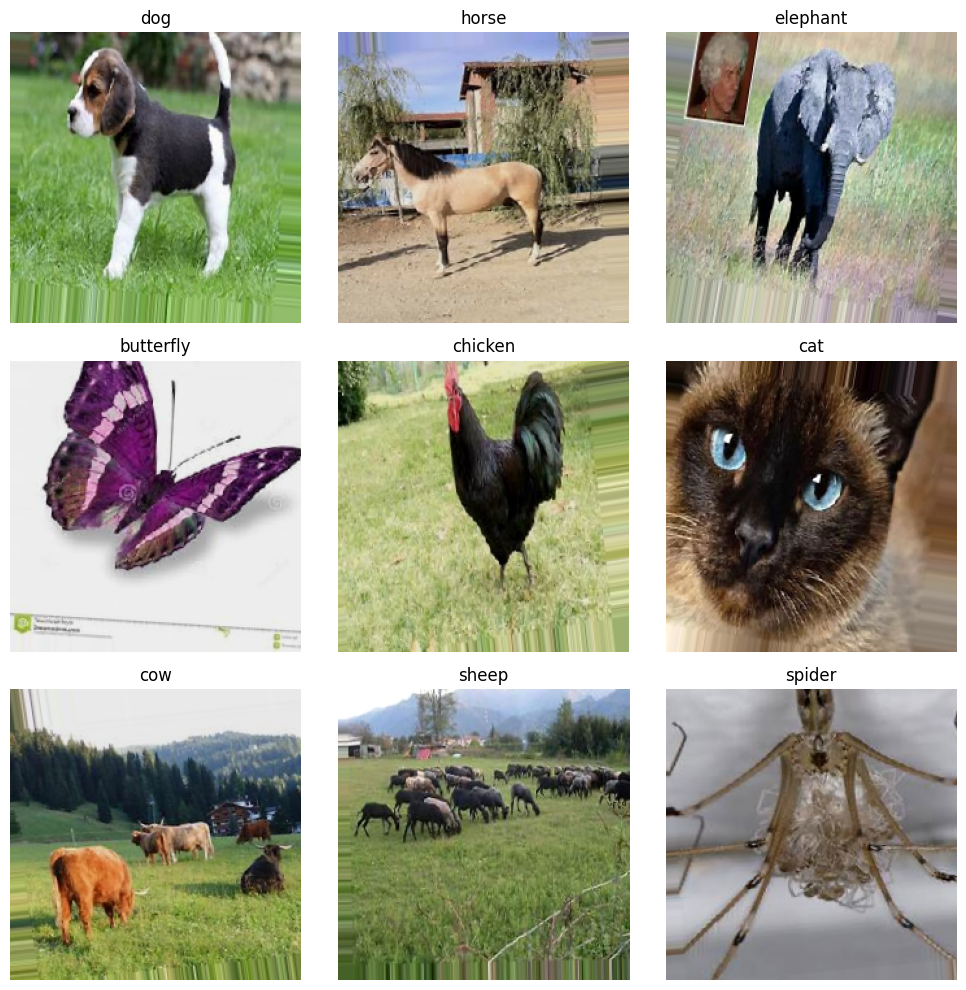

In [9]:
x_batch, y_batch = next(train_gen)

# Encontrar clases únicas en el batch
unique_classes = np.unique(np.argmax(y_batch, axis=1))

plt.figure(figsize=(10,10))

# Mostrar hasta 9 clases diferentes
for i, class_idx in enumerate(unique_classes[:9]):
    # Seleccionar la primera imagen de esa clase
    img_idx = np.where(np.argmax(y_batch, axis=1) == class_idx)[0][0]

    plt.subplot(3,3,i+1)
    plt.imshow(x_batch[img_idx])

    # Obtener nombre de clase y traducir a inglés
    label_name = list(train_gen.class_indices.keys())[class_idx]
    label_name = translate_to_english.get(label_name, label_name)

    plt.title(label_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
train_gen.class_indices = {translate_to_english[k]: v for k, v in train_gen.class_indices.items()}
val_gen.class_indices   = {translate_to_english[k]: v for k, v in val_gen.class_indices.items()}

print("Clases en inglés:", train_gen.class_indices)

Clases en inglés: {'dog': 0, 'horse': 1, 'elephant': 2, 'butterfly': 3, 'chicken': 4, 'cat': 5, 'cow': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}


2 . Model Architecture

- Design a CNN architecture suitable for image classification.
- Include convolutional layers, pooling layers, and fully connected layers.

In [11]:
img_height, img_width = 224, 224
batch_size = 64

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

Haciendo el Modelo

In [13]:
num_classes = 10  # 10 animales

model = models.Sequential([
    # --- Block 1 ---
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224,224,3)),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    # --- Block 2 ---
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    # --- Block 3 ---
    layers.Conv2D(224, (3,3), activation='relu', padding='same'),
    layers.Conv2D(224, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    # --- Fully Connected ---
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # regularización para evitar overfitting
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 224)    │       129,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 224)    │       451,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 224)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 175616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    44,957,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,607,146 (173.98 MB)

 Trainable params: 45,607,146 (173.98 MB)

 Non-trainable params: 0 (0.00 B)

3. Model Training

- Train the CNN model using appropriate optimization techniques (e.g., stochastic gradient descent, Adam).
- Utilize techniques such as early stopping to prevent overfitting.

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True
)

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calcular pesos inversamente proporcionales al tamaño de clase
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("Pesos de clase:", class_weights)

Pesos de clase: {0: np.float64(0.5383448984836803), 1: np.float64(0.9979514054311577), 2: np.float64(1.810458081244598), 3: np.float64(1.2394674556213017), 4: np.float64(0.8449778136345301), 5: np.float64(1.569063670411985), 6: np.float64(1.4030140656396517), 7: np.float64(1.4386675824175825), 8: np.float64(0.5430904848327716), 9: np.float64(1.4058389261744966)}


In [18]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    batch_size=64,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2362 - loss: 2.1057

328/328 ━━━━━━━━━━━━━━━━━━━━ 482s 1s/step - accuracy: 0.2364 - loss: 2.1053 - val_accuracy: 0.3601 - val_loss: 1.7822
Epoch 2/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.3930 - loss: 1.7519

328/328 ━━━━━━━━━━━━━━━━━━━━ 338s 1s/step - accuracy: 0.3930 - loss: 1.7518 - val_accuracy: 0.4776 - val_loss: 1.5056
Epoch 3/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.4716 - loss: 1.5422

328/328 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.4716 - loss: 1.5421 - val_accuracy: 0.5401 - val_loss: 1.3337
Epoch 4/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.5181 - loss: 1.4174

328/328 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.5181 - loss: 1.4173 - val_accuracy: 0.5925 - val_loss: 1.2081
Epoch 5/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.5516 - loss: 1.3068

328/328 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.5516 - loss: 1.3068 - val_accuracy: 0.6149 - val_loss: 1.1217
Epoch 6/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.5833 - loss: 1.2200

328/328 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.5833 - loss: 1.2200 - val_accuracy: 0.6282 - val_loss: 1.1098
Epoch 7/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.6111 - loss: 1.1576

328/328 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.6111 - loss: 1.1576 - val_accuracy: 0.6516 - val_loss: 1.0262
Epoch 8/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.6258 - loss: 1.0888

328/328 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.6258 - loss: 1.0888 - val_accuracy: 0.6762 - val_loss: 0.9596
Epoch 9/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.6466 - loss: 1.0370

328/328 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.6466 - loss: 1.0369 - val_accuracy: 0.7057 - val_loss: 0.9087
Epoch 10/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.6632 - loss: 0.9885 - val_accuracy: 0.6779 - val_loss: 0.9797
Epoch 11/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.6754 - loss: 0.9553 - val_accuracy: 0.7030 - val_loss: 0.8732
Epoch 12/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - accuracy: 0.6830 - loss: 0.9319 - val_accuracy: 0.7016 - val_loss: 0.8888
Epoch 13/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.6980 - loss: 0.8881

328/328 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.6980 - loss: 0.8881 - val_accuracy: 0.7232 - val_loss: 0.8112
Epoch 14/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.7145 - loss: 0.8398

328/328 ━━━━━━━━━━━━━━━━━━━━ 337s 1s/step - accuracy: 0.7145 - loss: 0.8398 - val_accuracy: 0.7282 - val_loss: 0.8119
Epoch 15/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.7197 - loss: 0.8315

328/328 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - accuracy: 0.7197 - loss: 0.8315 - val_accuracy: 0.7397 - val_loss: 0.7910
Epoch 16/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.7315 - loss: 0.7963

328/328 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.7315 - loss: 0.7963 - val_accuracy: 0.7471 - val_loss: 0.7691
Epoch 17/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.7319 - loss: 0.7897

328/328 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.7319 - loss: 0.7897 - val_accuracy: 0.7573 - val_loss: 0.7385
Epoch 18/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.7411 - loss: 0.7695 - val_accuracy: 0.7565 - val_loss: 0.7354
Epoch 19/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.7492 - loss: 0.7399

328/328 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.7492 - loss: 0.7398 - val_accuracy: 0.7716 - val_loss: 0.7242
Epoch 20/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.7511 - loss: 0.7366 - val_accuracy: 0.7662 - val_loss: 0.7037
Epoch 21/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - accuracy: 0.7600 - loss: 0.7097 - val_accuracy: 0.7676 - val_loss: 0.7042
Epoch 22/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.7629 - loss: 0.6982

328/328 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.7629 - loss: 0.6982 - val_accuracy: 0.7777 - val_loss: 0.6796
Epoch 23/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.7753 - loss: 0.6716

328/328 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - accuracy: 0.7752 - loss: 0.6716 - val_accuracy: 0.7798 - val_loss: 0.6583
Epoch 24/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.7818 - loss: 0.6467 - val_accuracy: 0.7741 - val_loss: 0.6837
Epoch 25/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step - accuracy: 0.7830 - loss: 0.6422 - val_accuracy: 0.7794 - val_loss: 0.6748
Epoch 26/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 337s 1s/step - accuracy: 0.7897 - loss: 0.6274 - val_accuracy: 0.7689 - val_loss: 0.7074
Epoch 27/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.7830 - loss: 0.6373

328/328 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.7830 - loss: 0.6372 - val_accuracy: 0.7810 - val_loss: 0.6685
Epoch 28/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.7933 - loss: 0.5906

328/328 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - accuracy: 0.7933 - loss: 0.5906 - val_accuracy: 0.7924 - val_loss: 0.6497
Epoch 29/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.7974 - loss: 0.6024 - val_accuracy: 0.7880 - val_loss: 0.6341
Epoch 30/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.8017 - loss: 0.5865

328/328 ━━━━━━━━━━━━━━━━━━━━ 337s 1s/step - accuracy: 0.8017 - loss: 0.5865 - val_accuracy: 0.7991 - val_loss: 0.6316
Epoch 31/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.8130 - loss: 0.5497

328/328 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.8130 - loss: 0.5498 - val_accuracy: 0.8008 - val_loss: 0.6252
Epoch 32/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - accuracy: 0.8137 - loss: 0.5547 - val_accuracy: 0.7928 - val_loss: 0.6375
Epoch 33/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.8191 - loss: 0.5422 - val_accuracy: 0.7938 - val_loss: 0.6398
Epoch 34/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - accuracy: 0.8193 - loss: 0.5290 - val_accuracy: 0.8003 - val_loss: 0.6239
Epoch 35/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.8294 - loss: 0.5010

328/328 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.8294 - loss: 0.5010 - val_accuracy: 0.8081 - val_loss: 0.6034
Epoch 36/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.8291 - loss: 0.4989 - val_accuracy: 0.8033 - val_loss: 0.6220
Epoch 37/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - accuracy: 0.8332 - loss: 0.4945 - val_accuracy: 0.8066 - val_loss: 0.5995
Epoch 38/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.8322 - loss: 0.4853

328/328 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - accuracy: 0.8322 - loss: 0.4854 - val_accuracy: 0.8117 - val_loss: 0.5909
Epoch 39/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.8363 - loss: 0.4870 - val_accuracy: 0.8085 - val_loss: 0.6352
Epoch 40/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.8358 - loss: 0.4747 - val_accuracy: 0.8071 - val_loss: 0.6045


4. Model Evaluation

- Evaluate the trained model on a separate validation set.
- ompute and report metrics such as accuracy, precision, recall, and F1-score.
- Visualize the confusion matrix to understand model performance across different classes.

In [19]:
val_loss, val_accuracy = model.evaluate(val_gen)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 66s 802ms/step - accuracy: 0.7951 - loss: 0.6259
Validation Loss: 0.6091
Validation Accuracy: 0.8003


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Obtener predicciones
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Etiquetas reales
y_true = val_gen.classes

# Nombres de clases
class_names = list(val_gen.class_indices.keys())

# Reporte de métricas
print(classification_report(y_true, y_pred_classes, target_names=class_names))

82/82 ━━━━━━━━━━━━━━━━━━━━ 65s 789ms/step
              precision    recall  f1-score   support

         dog       0.18      0.20      0.19       972
       horse       0.10      0.10      0.10       524
    elephant       0.08      0.07      0.07       289
   butterfly       0.07      0.08      0.08       422
     chicken       0.12      0.12      0.12       619
         cat       0.04      0.03      0.04       333
         cow       0.06      0.06      0.06       373
       sheep       0.07      0.07      0.07       364
      spider       0.19      0.18      0.19       964
    squirrel       0.07      0.07      0.07       372

    accuracy                           0.12      5232
   macro avg       0.10      0.10      0.10      5232
weighted avg       0.12      0.12      0.12      5232



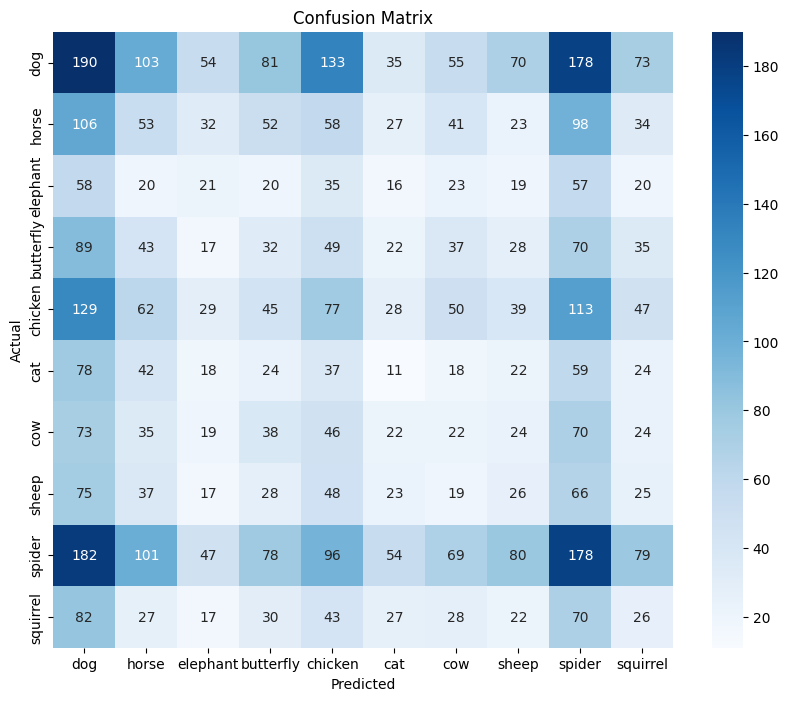

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Fine-tuning

In [22]:
# 1️⃣ Descongelar las últimas capas convolucionales
for layer in model.layers[-6:]:  # por ejemplo, las últimas 6 capas convolucionales
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer.trainable = True

# 2️⃣ Compilar nuevamente con learning rate más bajo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,  # pocas épocas para no sobreajustar
    batch_size=batch_size,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/10
 58/328 ━━━━━━━━━━━━━━━━━━━━ 3:41 820ms/step - accuracy: 0.8472 - loss: 0.4240

KeyboardInterrupt: 

In [ ]:
val_loss, val_accuracy = model.evaluate(val_gen)
print(f"Validation Loss (Fine-tuning): {val_loss:.4f}")
print(f"Validation Accuracy (Fine-tuning): {val_accuracy:.4f}")

Transfer Learning - MobileNetV2

In [ ]:
#Transfer Learning

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1️⃣ Cargar MobileNetV2 preentrenado (sin la capa superior)
base_model = MobileNetV2(input_shape=(224,224,3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # congelamos el backbone

# 2️⃣ Construir el modelo final
model_tl = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# 3️⃣ Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_mobilenet.keras', monitor='val_accuracy', save_best_only=True)

# 4️⃣ Compilar
model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# 5️⃣ Entrenar
history_tl = model_tl.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    batch_size=batch_size,
    callbacks=[early_stop, checkpoint]

In [ ]:
#Evaluar
val_loss, val_accuracy = model_tl.evaluate(val_gen)
print(f"Validation Loss (TL): {val_loss:.4f}")
print(f"Validation Accuracy (TL): {val_accuracy:.4f}")